In [1]:
# VENV TO USE: env_general_desktop

%matplotlib inline

# import SAIL_python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKagg')
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()
import pickle
from tableone import TableOne

import os
os.chdir('p:/postb/work/rahim_work/')

In [20]:
from scipy.stats import ttest_ind

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
path = 'S:/1323 - Using AI and machine learning to track the longitudinal primary to critical/ben/2023_04_04_p_drive_backup/rahim_work/'

In [34]:
# Read in tables

# path = 'p:/postb/work/rahim_work/'
df_raw = pd.read_pickle(path+'pkl_dfs/raw_rahimian_study_table_2018')
admissions = pd.read_pickle(path+'pkl_dfs/all_admissions')
deaths = pd.read_pickle(path+'pkl_dfs/all_deaths')

In [ ]:
# this is updated as the previous function didn't capture the rahimian methods correctly

def clean_and_join_rahimian(df, admissions, deaths, study_year):
    '''
    Very important - study_year here now refers to the start year of a 2 year period 
    i.e. if you want to look at the years 2016-2017, you set study_year == 2016
    because rahimian looked for outcomes 24 months after a 'start' date 
    '''
    # get patients who died in target year and merge with main table
    died = deaths[deaths['DEATH_YEAR'] == study_year][['ALF_PE','DEATH_YEAR']]
    df = df.merge(died,how ='left', on = 'ALF_PE')
    # drop patients that died before the target year
    df = df[~df.ALF_PE.isin(deaths[deaths['DEATH_YEAR'] < study_year]['ALF_PE'])]
    # fill death col with 0s if patient not recorded as dying that year
    df['DEATH_YEAR'] = df['DEATH_YEAR'].fillna(0)

    # get age at beginning of study period 
    df['study_age'] = study_year - df['BIRTH_YEAR']
    df = df.query('study_age >=18')

    # get admissions for target year
    admissions_target_years = admissions[['ALF_PE', f'ADM_{study_year}', f'ADM_{study_year+1}']]
    # merge with main table
    df = df.merge(admissions_target_years, how = 'left', on='ALF_PE')
    # fill all admission years with 0s if NaN - presume no admission
    cols = pd.Series(df.columns)
    cols = cols[cols.str.contains('adm_', case=False)]
    df[cols] = df[cols].fillna(0)

    # create a column to indicate if a patient died or was admitted in target year
    def admit(dataframe):
        if (dataframe[f'ADM_{study_year}']>=1 or dataframe[f'ADM_{study_year+1}']>=1):
            return 1
        else:
            return 0

    tqdm.pandas()
    # this may take a while to run with the whole dataset
    print('Creating death or admission outcome column: ')
    df['admit'] = df.apply(admit, axis=1)

    # mutate dataframe to replace dates of diagnosis with 1/0 if diagnosis present for study year
    # if year of diagnosis is less than study year then presume diagnosis present (1), otherwise presume diagnosis absent (0)
    def diagnosis_filler(x):
        if pd.isnull(x):
            return 0
        elif pd.to_datetime(x, errors='coerce').year < study_year: # coercing errors returns NaT where date is invlid
            return 1
        else:
            return 0

    # columns to mutate
    # df.columns.tolist()
    cols = ['HYPERTENSION', 'DIABETES', 'AF', 'IHD', 'VTE', 'CKD', 'VALVULAR', 'CCF', 'CANCER', 'ASTHMA_COPD',
            'EPILEPSY', 'FALLS', 'DEPRESSION', 'CHOL', 'MANIA_SCHIZO', 'CLD_PANC', 'RA_SLE',
            'OA', 'CTD', 'HEMIPLEGIA', 'HIV', 'LDS', 'OBESITY', 'OSTEOPOROSIS', 'PVD', 'PUD', 'DRUG_ABUSE']

    print('Converting PMH columns: ')
    for col in cols:
        df[col] = df[col].apply(diagnosis_filler)

    # fill ethnicity, lsoa, marital_status column with unknown if null
    df[['ETHNICITY','LSOA_DESC', 'MARITAL_STATUS']] = df[['ETHNICITY','LSOA_DESC', 'MARITAL_STATUS']].fillna('unknown')

    # fill WIMD values with median (needs to be rounded as WIMD values are integers)
    df['WIMD_2014_DECILE'] = df['WIMD_2014_DECILE'].fillna(np.round(df['WIMD_2014_DECILE'].median()))

    # fill smoking and etoh columns with 'no' - assume non-smoker/drinker if unknown
    df[['SMOKING','ETOH']] = df[['SMOKING','ETOH']].fillna('no')

    # fill FH column with 0 (no family history of diseased recorded)
    df['FH'] = df['FH'].fillna(0)

    # fill BMI column with median BMI
    df['BMI'] = df['BMI'].fillna(df['BMI'].median())

    # fill gp_visits/hosp_visits with 0 if null
    df[f'GP_VISITS_{study_year-1}'] = df[f'GP_VISITS_{study_year-1}'].fillna(0)
    df[f'HOSP_VISITS_{study_year-1}'] = df[f'HOSP_VISITS_{study_year-1}'].fillna(0)

    # harder to know what to do with time from admission/gp if null as this indicates there wasn't a visit
    # fill with median for now
    df['TIME_FROM_GP'] = df['TIME_FROM_GP'].fillna(100000)
    df['TIME_FROM_ADMISSION'] = df['TIME_FROM_ADMISSION'].fillna(100000)

    # repeat above for all other cols that have to do with time
    time_cols = df.columns
    time_cols = time_cols[time_cols.str.contains('_time', case=False)]

    # Fill with median value:
    # this is clearly not principled and needs to be discussed
    for col in time_cols:
        df[col] = df[col].fillna(100000)
        # # makes all values 0 if the column is all NaNs - e.g. diagnosis of HIV is uncommon
        # else:
        #     df[col] = df[col].fillna(0)
        #     print(f'{col} has no values')

    # fill indicator columns with 0 if value not present
    ind_cols = df.columns
    ind_cols = ind_cols[ind_cols.str.contains('_ind', case=False)]
    for col in ind_cols:
        df[col] = df[col].fillna(0)

    # fill abnormal blood result indicator columns with 0 if value not present
    abnormal_cols = df.columns
    abnormal_cols = abnormal_cols[abnormal_cols.str.contains('_abnormal', case=False)]
    for col in abnormal_cols:
        df[col] = df[col].fillna(0)

    # fill drug columns with 1 if a prescription was present before the study period

    drug_cols = ['STATIN', 'NSAID', 'ANTICOAG', 'STEROID', 'ANTIDEPRESS', 'ANTIPSYCH']
    for col in drug_cols:
        df[col] = df[col].apply(lambda x: 1 if x <study_year else 0)

    # fill blood test results with median values

    lab_cols = ['HB', 'CHDL', 'BILI', 'PLT', 'ESR', 'SBP']
    # there are some results that have < or > - these are mostly in the bili columns
    # if I strip the < or > signs then this will give at least give an idea of the true value
    for col in lab_cols:
        df[col] = df[col].str.lstrip('<>')
    # convert to numeric values
    for col in lab_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # fill with median value
    for col in lab_cols:
        df[col] = df[col].fillna(df[col].median())

    # create dummies for relevant columns

    dummy_cols = ['ETHNICITY', 'LSOA_DESC', 'SMOKING', 'ETOH', 'MARITAL_STATUS']
    dummy_df = pd.DataFrame(index = df.index)

    # create dummies
    for col in dummy_cols:
        dummies = pd.get_dummies(df[col])
        dummies = dummies.add_prefix(f'{col.lower()}_')
        dummy_df = dummy_df.merge(dummies, how = 'left', left_index=True, right_index=True)

    df = df.merge(dummy_df, left_index=True, right_index=True, how ='left')

    # drop columns that are now represented by dummies
    df = df.drop(columns = dummy_cols)

    # turn gender col into indicator col
    df['GNDR_CD'] = df['GNDR_CD'].astype('int')
    # this turns the gender column into a dummy variable col
    # in original data 1 = male, 2 = female
    df['GNDR_CD'] = df['GNDR_CD'].apply(lambda x: 0 if x==1 else 1)

    # the whole df takes a while to create so pickle
    filename = 'cleaned_rahim_CORRECT_' + str(study_year)
    pickle.dump(df, open('pkl_dfs/'+filename,'wb'))

    return df

study_df = clean_and_join_rahimian(df_raw, admissions, deaths, study_year=2018)
study_df

In [21]:
# study_df.filter(items=[,'STUDY_AGE','age_2017'])
pd.set_option('display.max_rows',1000)
pd.Series(study_df.columns)

0                             ALF_PE
1                         BIRTH_YEAR
2                           AGE_2017
3                            GNDR_CD
4                   WIMD_2014_DECILE
5                                 FH
6                                BMI
7                   HOSP_VISITS_2017
8                TIME_FROM_ADMISSION
9                     GP_VISITS_2017
10                      TIME_FROM_GP
11                      HYPERTENSION
12                 HYPERTENSION_TIME
13                          DIABETES
14                     DIABETES_TIME
15                                AF
16                           AF_TIME
17                               IHD
18                          IHD_TIME
19                               VTE
20                          VTE_TIME
21                               CKD
22                          CKD_TIME
23                          VALVULAR
24                     VALVULAR_TIME
25                               CCF
26                          CCF_TIME
2

## Get table 1, etc

In [3]:
%%time
# this is updated as the previous function didn't capture the rahimian methods correctly

def rahim_with_missingness(df, admissions, deaths, study_year):
    '''
    Very important - study_year here now refers to the start year of a 2 year period 
    i.e. if you want to look at the years 2016-2017, you set study_year == 2016
    because rahimian looked for outcomes 24 months after a 'start' date 
    '''
    # get patients who died in target year and merge with main table
    died = deaths[deaths['DEATH_YEAR'] == study_year][['ALF_PE','DEATH_YEAR']]
    df = df.merge(died,how ='left', on = 'ALF_PE')
    # drop patients that died before the target year
    df = df[~df.ALF_PE.isin(deaths[deaths['DEATH_YEAR'] < study_year]['ALF_PE'])]
    # fill death col with 0s if patient not recorded as dying that year
    df['DEATH_YEAR'] = df['DEATH_YEAR'].fillna(0)

    # get age at beginning of study period 
    df['study_age'] = study_year - df['BIRTH_YEAR']
    df = df.query('study_age >=18').query('study_age <= 100')
    
    # get admissions for target year
    admissions_target_years = admissions[['ALF_PE', f'ADM_{study_year}', f'ADM_{study_year+1}']]
    # merge with main table
    df = df.merge(admissions_target_years, how = 'left', on='ALF_PE')
    # fill all admission years with 0s if NaN - presume no admission
    cols = pd.Series(df.columns)
    cols = cols[cols.str.contains('adm_', case=False)]
    df[cols] = df[cols].fillna(0)

    # create a column to indicate if a patient died or was admitted in target year
    def admit(dataframe):
        if (dataframe[f'ADM_{study_year}']>=1 or dataframe[f'ADM_{study_year+1}']>=1):
            return 1
        else:
            return 0

    tqdm.pandas()
    # this may take a while to run with the whole dataset
    print('Creating death or admission outcome column: ')
    df['admit'] = df.apply(admit, axis=1)

    # mutate dataframe to replace dates of diagnosis with 1/0 if diagnosis present for study year
    # if year of diagnosis is less than study year then presume diagnosis present (1), otherwise presume diagnosis absent (0)
    def diagnosis_filler(x):
        if pd.isnull(x):
            return 0
        elif pd.to_datetime(x, errors='coerce').year < study_year: # coercing errors returns NaT where date is invlid
            return 1
        else:
            return 0

    # columns to mutate
    # df.columns.tolist()
    cols = ['HYPERTENSION', 'DIABETES', 'AF', 'IHD', 'VTE', 'CKD', 'VALVULAR', 'CCF', 'CANCER', 'ASTHMA_COPD',
            'EPILEPSY', 'FALLS', 'DEPRESSION', 'CHOL', 'MANIA_SCHIZO', 'CLD_PANC', 'RA_SLE',
            'OA', 'CTD', 'HEMIPLEGIA', 'HIV', 'LDS', 'OBESITY', 'OSTEOPOROSIS', 'PVD', 'PUD', 'DRUG_ABUSE']

    print('Converting PMH columns: ')
    for col in cols:
        df[col] = df[col].apply(diagnosis_filler)

    drug_cols = ['STATIN', 'NSAID', 'ANTICOAG', 'STEROID', 'ANTIDEPRESS', 'ANTIPSYCH']
    for col in drug_cols:
        df[col] = df[col].apply(lambda x: 1 if x <study_year else 0)
    
#     remove unwanted columns
    df = df.drop(columns = ['BIRTH_YEAR','AGE_2017','ADM_2018','ADM_2019','DEATH_YEAR'])
    
    drop_substrings = ['_time','_TIME','_IND','_ABNORMAL']
    cols_to_keep = df.columns[~df.columns.str.contains('|'.join(drop_substrings))]
    df = df.filter(items=cols_to_keep)

    # convert necessary columns to numeric
    df[['HB','CHDL', 'BILI', 'PLT', 'ESR', 'SBP']] = df[['HB','CHDL', 'BILI', 'PLT', 'ESR', 'SBP']].apply(pd.to_numeric, errors='coerce')

    return df

tab1_df = rahim_with_missingness(df_raw, admissions, deaths, study_year=2018)
tab1_df

In [100]:
pickle.dump(tab1_df, open(path+'/pkl_dfs/table_one_dataframe','wb'))

In [9]:
tab1_df = pd.read_pickle(path+'/pkl_dfs/table_one_dataframe')

In [1]:
# explore if normally distributed

variables = [
    'study_age', 'HOSP_VISITS_2017',
             'TIME_FROM_ADMISSION', 'GP_VISITS_2017', 'TIME_FROM_GP', 'CHDL', 'BILI', 'PLT', 'ESR', 'SBP'
            ]

for variable in variables:
    print(variable)
    sns.histplot(tab1_df[variable])
    plt.show()

In [9]:
columns = [
    'study_age', 'GNDR_CD', 'ETHNICITY', 'LSOA_DESC', 'WIMD_2014_DECILE',
    'SMOKING', 'ETOH', 'FH', 'MARITAL_STATUS', 'BMI', 'HOSP_VISITS_2017',
    'TIME_FROM_ADMISSION', 'GP_VISITS_2017', 'TIME_FROM_GP', 'HYPERTENSION',
    'DIABETES', 'AF', 'IHD', 'VTE', 'CKD', 'VALVULAR', 'CCF', 'CANCER',
    'ASTHMA_COPD', 'EPILEPSY', 'FALLS', 'DEPRESSION', 'CHOL',
    'MANIA_SCHIZO', 'CLD_PANC', 'RA_SLE', 'OA', 'CTD', 'HEMIPLEGIA', 'HIV',
    'LDS', 'OBESITY', 'OSTEOPOROSIS', 'PVD', 'PUD', 'DRUG_ABUSE', 'HB',
    'CHDL', 'BILI', 'PLT', 'ESR', 'SBP', 'STATIN', 'NSAID', 'ANTICOAG',
    'STEROID', 'ANTIDEPRESS', 'ANTIPSYCH', 'admit'
        ]

categorical = [
    'GNDR_CD','WIMD_2014_DECILE','FH','ETHNICITY', 'LSOA_DESC', 'SMOKING', 'ETOH', 'MARITAL_STATUS', 'HYPERTENSION',
    'DIABETES', 'AF', 'IHD', 'VTE', 'CKD', 'VALVULAR', 'CCF', 'CANCER', 'ASTHMA_COPD', 'EPILEPSY', 'FALLS', 
    'DEPRESSION', 'CHOL', 'MANIA_SCHIZO', 'CLD_PANC', 'RA_SLE', 'OA', 'CTD', 'HEMIPLEGIA', 'HIV',
    'LDS', 'OBESITY', 'OSTEOPOROSIS', 'PVD', 'PUD', 'DRUG_ABUSE', 'STATIN', 'NSAID', 'ANTICOAG',
       'STEROID', 'ANTIDEPRESS', 'ANTIPSYCH'
              ]

order = {'WIMD_2014_DECILE':{1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0},
        'HYPERTENSION':{'1','0'}, 'DIABETES':{'1','0'}, 'AF':{'1','0'}, 'IHD':{'1','0'}, 'VTE':{'1','0'}, 'CKD':{'1','0'}, 
        'VALVULAR':{'1','0'}, 'CCF':{'1','0'}, 'CANCER':{'1','0'},'ASTHMA_COPD':{'1','0'}, 'EPILEPSY':{'1','0'}, 
        'FALLS':{'1','0'}, 'DEPRESSION':{'1','0'}, 'CHOL':{'1','0'}, 'MANIA_SCHIZO':{'1','0'}, 'CLD_PANC':{'1','0'},
        'RA_SLE':{'1','0'}, 'OA':{'1','0'}, 'CTD':{'1','0'}, 'HEMIPLEGIA':{'1','0'}, 'HIV':{'1','0'}, 'LDS':{'1','0'}, 
        'OBESITY':{'1','0'}, 'OSTEOPOROSIS':{'1','0'}, 'PVD':{'1','0'}, 'PUD':{'1','0'}, 'DRUG_ABUSE':{'1','0'},
        'STATIN':{'1','0'}, 'NSAID':{'1','0'}, 'ANTICOAG':{'1','0'}, 'STEROID':{'1','0'}, 'ANTIDEPRESS':{'1','0'}, 
        'ANTIPSYCH':{'1','0'}
        }

nonnormal = ['study_age', 'HOSP_VISITS_2017','TIME_FROM_ADMISSION', 'GP_VISITS_2017', 'TIME_FROM_GP', 'BILI', 'ESR']

groupby = ['admit']

# columns = tab1_df.columns.drop(['ALF_PE','TIME_FROM_GP','TIME_FROM_ADMISSION']).to_list()


limit = {
    'HYPERTENSION':1, 'DIABETES':1, 'AF':1, 'IHD':1, 'VTE':1, 'CKD':1, 'VALVULAR':1, 'CCF':1, 'CANCER':1,
    'ASTHMA_COPD':1, 'EPILEPSY':1, 'FALLS':1, 'DEPRESSION':1, 'CHOL':1, 'MANIA_SCHIZO':1, 'CLD_PANC':1, 'RA_SLE':1, 
    'OA':1, 'CTD':1, 'HEMIPLEGIA':1, 'HIV':1, 'LDS':1, 'OBESITY':1, 'OSTEOPOROSIS':1, 'PVD':1, 'PUD':1, 'DRUG_ABUSE':1,
    'STATIN':1, 'NSAID':1, 'ANTICOAG':1,'STEROID':1, 'ANTIDEPRESS':1, 'ANTIPSYCH':1,
    'admit':0
}

In [12]:
%%time
tableone = TableOne(data=tab1_df_cleaned_for_TableOne, 
                    columns=columns, 
                    categorical = categorical, 
                    order=order, 
                    groupby=groupby,
                    nonnormal = nonnormal,
                    limit=limit, 
                    pval=True)
tableone

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Order value not found: HIV: ['1']


CPU times: total: 13min 18s
Wall time: 13min 18s


iteritems is deprecated and will be removed in a future version. Use .items instead.


Grouped by admit                                                                    
                                                                   Missing             Overall                   0                   1 P-Value
n                                                                                      3296146             2650091              646055        
study_age, median [Q1,Q3]                                                0    46.0 [32.0,63.0]    44.0 [31.0,59.0]    58.0 [38.0,73.0]  <0.001
GNDR_CD, n (%)                      1                                    0      1626744 (49.4)      1350350 (51.0)       276394 (42.8)  <0.001
                                    2                                           1669402 (50.6)      1299741 (49.0)       369661 (57.2)        
ETHNICITY, n (%)                    african                        2552877          5983 (0.8)          5208 (0.9)           775 (0.4)  <0.001
                                    arab                                            2538 (0.3)          2229 (0.4)           309 (0.2)        
                                    asian_other                                     9855 (1.3)          9001 (1.6)           854 (0.5)        
                                    bangladeshi                                     3148 (0.4)          2562 (0.5)           586 (0.3)        
                                    black                                           2533 (0.3)          2227 (0.4)           306 (0.2)        
                                    brit_or_mixed_brit                           327943 (44.1)       246048 (43.4)        81895 (46.5)        
                                    caribbean                                        729 (0.1)           602 (0.1)           127 (0.1)        
                                    chinese                                         9402 (1.3)          9047 (1.6)           355 (0.2)        
                                    indian                                          8302 (1.1)          7567 (1.3)           735 (0.4)        
                                    mixed                                           9064 (1.2)          7858 (1.4)          1206 (0.7)        
                                    not_stated                                     31879 (4.3)         24974 (4.4)          6905 (3.9)        
                                    other                                         89878 (12.1)        75940 (13.4)         13938 (7.9)        
                                    pakistani                                       3966 (0.5)          3272 (0.6)           694 (0.4)        
                                    white                                        238049 (32.0)       170701 (30.1)        67348 (38.3)        
LSOA_DESC, n (%)                    Blaenau Gwent                        0         63936 (1.9)         46262 (1.7)         17674 (2.7)  <0.001
                                    Bridgend                                      146367 (4.4)        113694 (4.3)         32673 (5.1)        
                                    Caerphilly                                    155395 (4.7)        113998 (4.3)         41397 (6.4)        
                                    Cardiff                                      502143 (15.2)       435925 (16.4)        66218 (10.2)        
                                    Carmarthenshire                               179549 (5.4)        138784 (5.2)         40765 (6.3)        
                                    Ceredigion                                    121908 (3.7)        107112 (4.0)         14796 (2.3)        
                                    Conwy                                         109636 (3.3)         87493 (3.3)         22143 (3.4)        
                                    Denbighshire                                   97295 (3.0)         78116 (2.9)         19179 (3.0)        
                                    Flintshire        

In [16]:
pickle.dump(tableone, open(path+'/tableone','wb'))

## Modelling 

In [94]:

# split data for QA/QA+/T as per rahimian paper
# QA
def get_qa_data(df):
    qa_df = df[[
            'ALF_PE',
            # Demographics
            'study_age','GNDR_CD',
            'ethnicity_african', 'ethnicity_arab', 'ethnicity_asian_other', 'ethnicity_bangladeshi', 'ethnicity_black',
            'ethnicity_brit_or_mixed_brit', 'ethnicity_caribbean', 'ethnicity_chinese', 'ethnicity_indian',
            'ethnicity_mixed', 'ethnicity_not_stated', 'ethnicity_other', 'ethnicity_pakistani', 'ethnicity_unknown', 'ethnicity_white',
            # Lifestyle and FH
            'WIMD_2014_DECILE', 'BMI',
            'smoking_ex', 'smoking_heavy', 'smoking_light', 'smoking_moderate', 'smoking_no', 'smoking_smoker_amount_unknown',
            'etoh_etoh_amount_unknown', 'etoh_ex', 'etoh_light', 'etoh_moderate', 'etoh_no', 'etoh_trivial', 'etoh_very_heavy', 'FH',
            'lsoa_desc_Blaenau Gwent', 'lsoa_desc_Bridgend', 'lsoa_desc_Caerphilly', 'lsoa_desc_Cardiff', 'lsoa_desc_Carmarthenshire',
            'lsoa_desc_Ceredigion', 'lsoa_desc_Conwy', 'lsoa_desc_Denbighshire', 'lsoa_desc_Flintshire', 'lsoa_desc_Gwynedd',
            'lsoa_desc_Isle of Anglesey', 'lsoa_desc_Merthyr Tydfil', 'lsoa_desc_Monmouthshire', 'lsoa_desc_Neath Port Talbot',
            'lsoa_desc_Newport', 'lsoa_desc_Pembrokeshire', 'lsoa_desc_Powys', 'lsoa_desc_Rhondda Cynon Taf', 'lsoa_desc_Swansea',
            'lsoa_desc_Torfaen', 'lsoa_desc_Vale of Glamorgan', 'lsoa_desc_Wrexham', 'lsoa_desc_unknown',
            # Use of care
            'HOSP_VISITS_2017',
            # Clinical diagnoses / comorbidities
            'DIABETES', 'AF', 'IHD', 'CCF','VTE', 'CANCER', 'ASTHMA_COPD', 'EPILEPSY', 'FALLS', 'MANIA_SCHIZO',
            'CKD', 'CLD_PANC', 'VALVULAR', 'HYPERTENSION', 'RA_SLE', 'DEPRESSION',
            # clinical measures/lab tests
            'SBP', 'SBP_IND', 'SBP_ABNORMAL', 'HB', 'HB_IND', 'HB_ABNORMAL', 'CHDL', 'CHDL_IND', 'CHDL_ABNORMAL',
            'BILI', 'BILI_IND', 'BILI_ABNORMAL', 'PLT', 'PLT_IND', 'PLT_ABNORMAL', 'ESR', 'ESR_IND', 'ESR_ABNORMAL',
            # DRUGS
            'STATIN', 'NSAID', 'ANTICOAG', 'STEROID', 'ANTIDEPRESS', 'ANTIPSYCH',
            # outcome
            'admit'
            ]]
    return qa_df

# QA+
def get_qa_plus_data(df):
    qa_plus_df = df[[
        'ALF_PE',
        # Demographics
        'study_age','GNDR_CD',
        'ethnicity_african', 'ethnicity_arab', 'ethnicity_asian_other', 'ethnicity_bangladeshi', 'ethnicity_black',
        'ethnicity_brit_or_mixed_brit', 'ethnicity_caribbean', 'ethnicity_chinese', 'ethnicity_indian',
        'ethnicity_mixed', 'ethnicity_not_stated', 'ethnicity_other', 'ethnicity_pakistani', 'ethnicity_unknown', 'ethnicity_white',
        # Lifestyle and FH
        'WIMD_2014_DECILE', 'BMI',
        'smoking_ex', 'smoking_heavy', 'smoking_light', 'smoking_moderate', 'smoking_no', 'smoking_smoker_amount_unknown',
        'etoh_etoh_amount_unknown', 'etoh_ex', 'etoh_light', 'etoh_moderate', 'etoh_no', 'etoh_trivial', 'etoh_very_heavy', 'FH',
        'lsoa_desc_Blaenau Gwent', 'lsoa_desc_Bridgend', 'lsoa_desc_Caerphilly', 'lsoa_desc_Cardiff', 'lsoa_desc_Carmarthenshire',
        'lsoa_desc_Ceredigion', 'lsoa_desc_Conwy', 'lsoa_desc_Denbighshire', 'lsoa_desc_Flintshire', 'lsoa_desc_Gwynedd',
        'lsoa_desc_Isle of Anglesey', 'lsoa_desc_Merthyr Tydfil', 'lsoa_desc_Monmouthshire', 'lsoa_desc_Neath Port Talbot',
        'lsoa_desc_Newport', 'lsoa_desc_Pembrokeshire', 'lsoa_desc_Powys', 'lsoa_desc_Rhondda Cynon Taf', 'lsoa_desc_Swansea',
        'lsoa_desc_Torfaen', 'lsoa_desc_Vale of Glamorgan', 'lsoa_desc_Wrexham', 'lsoa_desc_unknown',
        'marital_status_cohabit', 'marital_status_divorced', 'marital_status_married', 'marital_status_separated',
        'marital_status_single', 'marital_status_unknown', 'marital_status_widowed',
        # Use of care
        'HOSP_VISITS_2017', 'GP_VISITS_2017',
        # Clinical diagnoses / comorbidities
        'DIABETES', 'AF', 'IHD', 'CCF','VTE', 'CANCER', 'ASTHMA_COPD', 'EPILEPSY', 'FALLS', 'MANIA_SCHIZO',
        'CKD', 'CLD_PANC', 'VALVULAR', 'HYPERTENSION', 'RA_SLE', 'DEPRESSION',
        'OA', 'CTD', 'HEMIPLEGIA', 'HIV', 'CHOL', 'LDS', 'OBESITY', 'OSTEOPOROSIS', 'PVD', 'PUD', 'DRUG_ABUSE',
        # clinical measures/lab tests
        'SBP', 'SBP_IND', 'SBP_ABNORMAL', 'HB', 'HB_IND', 'HB_ABNORMAL', 'CHDL', 'CHDL_IND', 'CHDL_ABNORMAL',
        'BILI', 'BILI_IND', 'BILI_ABNORMAL', 'PLT', 'PLT_IND', 'PLT_ABNORMAL', 'ESR', 'ESR_IND', 'ESR_ABNORMAL',
        # DRUGS
        'STATIN', 'NSAID', 'ANTICOAG', 'STEROID', 'ANTIDEPRESS', 'ANTIPSYCH',
        # outcome
        'admit'
    ]]
    return qa_plus_df

# T
def get_t_data(df):
    t_df = df[[
        'ALF_PE',
        # Demographics
        'study_age','GNDR_CD',
        'ethnicity_african', 'ethnicity_arab', 'ethnicity_asian_other', 'ethnicity_bangladeshi', 'ethnicity_black',
        'ethnicity_brit_or_mixed_brit', 'ethnicity_caribbean', 'ethnicity_chinese', 'ethnicity_indian',
        'ethnicity_mixed', 'ethnicity_not_stated', 'ethnicity_other', 'ethnicity_pakistani', 'ethnicity_unknown', 'ethnicity_white',
        # Lifestyle and FH
        'WIMD_2014_DECILE', 'BMI',
        'smoking_ex', 'smoking_heavy', 'smoking_light', 'smoking_moderate', 'smoking_no', 'smoking_smoker_amount_unknown',
        'etoh_etoh_amount_unknown', 'etoh_ex', 'etoh_light', 'etoh_moderate', 'etoh_no', 'etoh_trivial', 'etoh_very_heavy', 'FH',
        'lsoa_desc_Blaenau Gwent', 'lsoa_desc_Bridgend', 'lsoa_desc_Caerphilly', 'lsoa_desc_Cardiff', 'lsoa_desc_Carmarthenshire',
        'lsoa_desc_Ceredigion', 'lsoa_desc_Conwy', 'lsoa_desc_Denbighshire', 'lsoa_desc_Flintshire', 'lsoa_desc_Gwynedd',
        'lsoa_desc_Isle of Anglesey', 'lsoa_desc_Merthyr Tydfil', 'lsoa_desc_Monmouthshire', 'lsoa_desc_Neath Port Talbot',
        'lsoa_desc_Newport', 'lsoa_desc_Pembrokeshire', 'lsoa_desc_Powys', 'lsoa_desc_Rhondda Cynon Taf', 'lsoa_desc_Swansea',
        'lsoa_desc_Torfaen', 'lsoa_desc_Vale of Glamorgan', 'lsoa_desc_Wrexham', 'lsoa_desc_unknown',
        'marital_status_cohabit', 'marital_status_divorced', 'marital_status_married', 'marital_status_separated',
        'marital_status_single', 'marital_status_unknown', 'marital_status_widowed',
        # Use of care
        'HOSP_VISITS_2017', 'TIME_FROM_ADMISSION', 'GP_VISITS_2017', 'TIME_FROM_GP',
        # Clinical diagnoses / comorbidities
        'DIABETES_TIME', 'AF_TIME', 'IHD_TIME', 'CCF_TIME', 'VTE_TIME', 'CANCER_TIME', 'ASTHMA_COPD_TIME', 'EPILEPSY_TIME',
        'FALLS_TIME',  'MANIA_SCHIZO_TIME', 'CKD_TIME', 'CLD_PANC_TIME', 'VALVULAR_TIME',  'HYPERTENSION_TIME', 'RA_SLE_TIME',
        'DEPRESSION_TIME','OA_TIME', 'CTD_TIME', 'HEMIPLEGIA_TIME', 'HIV_TIME', 'CHOL_TIME',
        'LDS_TIME', 'OBESITY_TIME', 'OSTEOPOROSIS_TIME', 'PVD_TIME', 'PUD_TIME', 'DRUG_ABUSE_TIME',
        # clinical measures/lab tests
        'SBP', 'SBP_ABNORMAL', 'HB', 'HB_ABNORMAL', 'CHDL', 'CHDL_ABNORMAL',
        'BILI', 'BILI_ABNORMAL', 'PLT', 'PLT_ABNORMAL', 'ESR', 'ESR_ABNORMAL',
        'HB_TIME', 'CHDL_TIME', 'BILI_TIME', 'PLT_TIME', 'ESR_TIME', 'SBP_TIME',
        # DRUGS
        'STATIN', 'NSAID', 'ANTICOAG', 'STEROID', 'ANTIDEPRESS', 'ANTIPSYCH',
        # outcome
        'admit'
    ]]
    return t_df



In [260]:
# these functions extract data that match the rahimian 3 data types

qa_df = get_qa_data(study_df)
qa_plus_df = get_qa_plus_data(study_df)
t_df = get_t_data(study_df)

In [261]:
# get train test ids

def get_train_test_data(df, test_size = 0.2, rand_state=42):
    '''
    :param df: the entire df with ALL patients
    :param test_size: test_size
    :param rand_state: random_state
    :return: ids for training, ids for testing (these can then be used for all different datasets for consistency)
    '''
    all_ids = df['ALF_PE']
    train_ids, test_ids = train_test_split(all_ids, test_size=test_size, random_state=rand_state)

    path = 'p:/postb/work/rahim_work/pkl_dfs/'
    pickle.dump(train_ids, open(path+'train_ids','wb'))
    pickle.dump(test_ids, open(path+'test_ids','wb'))

    return train_ids, test_ids



train_ids, test_ids = get_train_test_data(study_df)

In [3]:
%%time
# do grid search

def grid_search_testing(df, train_ids, test_ids, dataname, save=False):
    # dataname is a string: 'qa', 'qa_p' or 't'

    training_df = df[df['ALF_PE'].isin(train_ids)]
    test_df = df[df['ALF_PE'].isin(test_ids)]
    
    training_df = training_df
    test_df = test_df
    
    X_train = training_df.drop(columns = ['ALF_PE','admit'])
    y_train = training_df['admit']
    X_test = test_df.drop(columns = ['ALF_PE','admit'])
    y_test = test_df['admit']

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    # fit and transform on train
    X_train = scaler.fit_transform(X_train)
    y_train = y_train.to_numpy() # this is needed for StratifiedKFold below
   
    
    # split X_train using K folds to get AUC, and calibration curves with CIs/STDs etc
    # IMPORTANT - THIS DOES NOT INCLUDE X_TEST (THIS IS SAVED FOR LATER)
    
    lr = LogisticRegression()
    lr_param_grid={
        'penalty' : ['l1','l2'],
        'max_iter':[1000],
        'class_weight':['balanced'],
        'solver':['liblinear']
        }
    rf = RandomForestClassifier()
    rf_param_grid=[
        {'class_weight': ['balanced'],
        'bootstrap' : [True],
        'max_depth':[4,5,6], # as per rahimian (5)
        'max_features':[0.5],# as per rahimian (.5)
        'min_samples_leaf':[3], #,4,5
        'min_samples_split':[0.005, 0.01], # as per rahimian (.01)
        'n_estimators':[400,800] # as per rahimian (800)
        }
    ]
    gbc = GradientBoostingClassifier()
    gbc_param_grid=[
        {'loss' : ['deviance'],
        'learning_rate': [0.01,0.025], 
         'max_depth':[4,5,6], # as per rahimian (5)
        'max_features':[0.5],# as per rahimian (.5)
        'min_samples_leaf':[3], #,4,5
        'min_samples_split':[0.005, 0.01], # as per rahimian (.01)
        'n_estimators':[400,800] # as per rahimian (800)
        } 
    ]
    models = [lr,rf,gbc]
    grids = [lr_param_grid, rf_param_grid,gbc_param_grid]
    labels = ['Logistic Regression', 'Random Forest', 'Gradient Boosting Classifier']
    positions = [1,2,3]
    colors = ['pink','navy','green']
    
    fig1, ax1 = plt.subplots(1,1, figsize=(15,9))
    fig2, ax2 = plt.subplots(1,1, figsize=(15,9))
    fig3, ax3 = plt.subplots(1,1, figsize=(15,9))
    
    global_rocs=[]
    global_f1s=[]
    best_params = []
    assoc_model = [] # this is used to keep track of what params relate to which model
    
    for model,grid,label,position,color in zip(models,grids,labels,positions,colors):
    
        all_rocs=[] # best one for each grid search loop
        all_f1s=[] # best one for each grid search loop
        tprs = []
        
        base_fpr = np.linspace(0,1,101)
        counter=1
        
        kf = StratifiedKFold(n_splits = 5)
        for train_index, test_index in kf.split(X_train,y_train):
            print(label, ' fold number: ', counter)
            cv_model = GridSearchCV(model, param_grid=grid, verbose=1)
            model_ = cv_model.fit(X_train[train_index],y_train[train_index])
            # return best parameters and best scores
            best_param = model_.best_params_
            best_params.append(best_param)
            # log labels so that for each value collected, we know which model this refers to
            assoc_model.append(label)
            # get predictions from model
            preds = model_.predict(X_train[test_index])
            # roc_score
            roc_score = roc_auc_score(y_train[test_index], preds)
            all_rocs.append(roc_score) # this is for the local plot
            global_rocs.append(roc_score) # this keeps track of all the roc values and can be returned 
            # f1_score
            f1 = f1_score(y_train[test_index], preds)
            all_f1s.append(f1) #as above
            global_f1s.append(f1) #as above
            
            # calibration plot
            probs = model_.predict_proba(X_train[test_index])
            prob_true, prob_pred = calibration_curve(y_train[test_index], probs[:,1], n_bins=10)
            tpr = np.interp(base_fpr, prob_pred, prob_true)
            tpr[0] = 0.0
            tprs.append(tpr)
            counter = counter+1
            
        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        tprs_upper = mean_tprs + std
        tprs_lower = mean_tprs - std
        
        ax1.plot(base_fpr, mean_tprs, label=label,color=color)
        ax1.fill_between(base_fpr, tprs_lower, tprs_upper, alpha=0.1,color=color)
        
        box = ax2.boxplot(all_rocs, positions=[position],patch_artist=True)
        for box_ in box['boxes']:
            box_.set(facecolor=color)
            
        box = ax3.boxplot(all_f1s, positions=[position],patch_artist=True)
        for box_ in box['boxes']:
            box_.set(facecolor=color)
    
    ax1.plot([0,1],[0,1],color='grey',linestyle='--',label=('Perfect Calibration'))
    ax1.set_xlabel('Predicted Probability',fontsize=16)
    ax1.set_ylabel('Proportion of True Positives', fontsize=16)
    ax1.set_title('Calibration Curve for QA Data', fontsize=20)
    ax1.legend()
    if save == True:
        fig1.savefig('plots_rahim/calibration_plots')
    else:
        pass
    
    ax2.set_xlabel('Model',fontsize=16)
    ax2.set_xticklabels(labels)
    ax2.set_ylabel('ROC_AUC',fontsize=16)
    ax2.set_title(f'Model Performance for {dataname} Data', fontsize=20)
    if save == True:
        fig2.savefig('plots_rahim/roc_auc_plots')
    else:
        pass
    
    ax3.set_xlabel('Model',fontsize=16)
    ax3.set_xticklabels(labels)
    ax3.set_ylabel('F1 Scores',fontsize=16)
    ax3.set_title('Model Performance for QA Data', fontsize=20)
    if save == True:
        fig3.savefig('plots_rahim/f1_plots')
    else:
        pass
    
           
    return global_rocs, global_f1s, best_params, assoc_model

## Train final models based on above parameters

In [480]:
%%time

def train_final_models(study_df, dataname):
    # dataname is a string: 'qa', 'qa_p' or 't'

    X_train = study_df.query('ALF_PE in @train_ids').drop(columns = ['ALF_PE','admit'])
    y_train = study_df.query('ALF_PE in @train_ids')['admit']
#     X_test = study_df.query('ALF_PE in @test_ids').drop(columns = ['ALF_PE','admit'])
#     y_test = study_df.query('ALF_PE in @test_ids')['admit']

    scaler = MinMaxScaler()
    # fit and transform on train
    X_train = scaler.fit_transform(X_train)
    y_train = y_train.to_numpy() # this is needed for StratifiedKFold below

#     # scale test data
#     X_test = scaler.fit(X_test)
#     y_test = y_test.to_numpy()

    lr = LogisticRegression(max_iter=1000, class_weight='balanced', penalty= 'l1', solver='liblinear')
    rf = RandomForestClassifier(bootstrap= True, class_weight='balanced', 
                                max_depth= 6, max_features= 0.5, min_samples_leaf=3, 
                                min_samples_split=0.005, n_estimators=400)
    gbc = GradientBoostingClassifier(learning_rate= 0.01, loss= 'deviance', 
                                     max_depth= 5, max_features= 0.5, min_samples_leaf= 3, 
                                     min_samples_split= 0.01, n_estimators= 800)
    models = [lr,rf,gbc]
    labels = ['lr','rf','gbc']
    
    model_dict ={}

    for model,label in tqdm(zip(models,labels)):
        cv_results = cross_validate(model, X_train,y_train, cv=5, scoring=['f1','roc_auc','precision','recall'],
                                    return_estimator=True
                      )
#         model_ = model.fit(X_train,y_train)
        
        model_dict[label] = cv_results
        
    model_dict['scaler'] = scaler

    return model_dict
    
# qa_model_dict = train_final_models(qa_df.sample(1000),dataname='qa')

CPU times: total: 0 ns
Wall time: 0 ns


In [487]:
%%time
qa_model_dict = train_final_models(qa_df,dataname='qa')
pickle.dump(qa_model_dict, open(path+'qa_model_dict','wb'))

0it [00:00, ?it/s]

CPU times: total: 15h 20min 37s
Wall time: 15h 20min 40s


In [488]:
%%time
qa_plus_model_dict = train_final_models(qa_plus_df,dataname='qa')
pickle.dump(qa_plus_model_dict, open(path+'qa_plus_model_dict','wb'))

0it [00:00, ?it/s]

CPU times: total: 17h 54min 3s
Wall time: 17h 54min 5s


In [489]:
%%time
t_model_dict = train_final_models(t_df,dataname='qa')
pickle.dump(t_model_dict, open(path+'t_model_dict','wb'))

0it [00:00, ?it/s]

CPU times: total: 23h 36min
Wall time: 23h 36min 3s


In [745]:
roc_table = pd.DataFrame()

custom_sort_order_0 = ['Logistic Regression','Random Forest', 'Gradient Boosting Classifier']

for df,dataname in zip([qa_all_performance,qa_plus_all_performance,t_all_performance],['QA','QA plus','T']):
    update_df = (
        df.groupby(['model','train_test'])['rocs'].agg(['max','mean','sem'])
        .assign(
            ci95_low = lambda x: x['mean'] - 1.96*x['sem'],
            ci95_high = lambda x: x['mean'] + 1.96*x['sem']
        )
        .drop(columns=['sem'])
        .rename(columns={'mean':f'{dataname} mean','max':f'{dataname} best'})
        .apply(lambda x: np.round(x,3))
#         .set_index('train_test',append=True, inplace=True)
    )
    roc_table = pd.concat([roc_table, update_df], axis=1)

    
# sort dataframe sensibly
roc_table = (
    roc_table
    .sort_index(level=0, key = lambda x: pd.Categorical(x, categories=custom_sort_order_0, ordered=True))
    .reset_index(level=1)
    .sort_values(by=['train_test'], ascending=False)
    .sort_index(level=0, key = lambda x: pd.Categorical(x, categories=custom_sort_order_0, ordered=True))
    .set_index('train_test',append=True)
)
roc_table.index.names = [None,None]
roc_table

QA best  QA mean  ci95_low  ci95_high  \
Logistic Regression          train    0.822    0.807     0.797      0.817   
                             test     0.749    0.732     0.721      0.742   
Random Forest                train    0.826    0.810     0.799      0.820   
                             test     0.751    0.733     0.722      0.744   
Gradient Boosting Classifier train    0.834    0.819     0.809      0.828   
                             test     0.614    0.609     0.603      0.614   

                                    QA plus best  QA plus mean  ci95_low  \
Logistic Regression          train         0.823         0.808     0.798   
                             test          0.749         0.732     0.721   
Random Forest                train         0.826         0.810     0.799   
                             test          0.749         0.731     0.720   
Gradient Boosting Classifier train         0.834         0.819     0.809   
                             test          0.616         0.609     0.603   

                                    ci95_high  T best  T mean  ci95_low  \
Logistic Regression          train      0.818   0.831   0.816     0.806   
                             test       0.742   0.752   0.736     0.726   
Random Forest                train      0.820   0.836   0.821     0.811   
                             test       0.742   0.761   0.744     0.733   
Gradient Boosting Classifier train      0.829   0.850   0.836     0.827   
                             test       0.615   0.642   0.636     0.630   

                                    ci95_high  
Logistic Regression          train      0.826  
                             test       0.746  
Random Forest                train      0.831  
                             test       0.754  
Gradient Boosting Classifier train      0.845  
                             test       0.642

## Feature Importance

In [682]:
model_dicts = [qa_model_dict, qa_plus_model_dict, t_model_dict]
dfs = [qa_df, qa_plus_df, t_df]
data_names = ['QA', 'QA Plus', 'T']

all_feature_importances = pd.DataFrame()

for model_dict, df, data_name in zip(model_dicts, dfs, data_names):

    # lr coefficients
    best_id = np.argmax(model_dict['lr']['test_roc_auc'])
    best_model = model_dict['lr']['estimator'][best_id]

    lr_coefs = (
        pd.DataFrame({'features':df.drop(columns = ['ALF_PE','admit']).columns,'coefficient':best_model.coef_[0]})
        .sort_values(by=['coefficient'], key=abs, ascending = False)
        .rename(columns={'features':f'LR Top Features - {data_name}'})
        .head(20)
        .reset_index(drop=True)
    )

    # RF feature importance
    best_id = np.argmax(model_dict['rf']['test_roc_auc'])
    best_model = model_dict['rf']['estimator'][best_id]

    rf_feature_importance = (
        pd.DataFrame({'features':df.drop(columns = ['ALF_PE','admit']).columns,'gini_importance':best_model.feature_importances_})
        .sort_values(by=['gini_importance'], key=abs, ascending = False)
        .rename(columns={'features':f'RF Top Features - {data_name}'})
        .head(20)
        .reset_index(drop=True)
    )

    # GBC feature importance
    best_id = np.argmax(model_dict['gbc']['test_roc_auc'])
    best_model = model_dict['gbc']['estimator'][best_id]

    gbc_feature_importance = (
        pd.DataFrame({'features':df.drop(columns = ['ALF_PE','admit']).columns,'gini_importance':best_model.feature_importances_})
        .sort_values(by=['gini_importance'], key=abs, ascending = False)
        .rename(columns={'features':f'GBC Top Features - {data_name}'})
        .head(20)
        .reset_index(drop=True)
    )
    
    all_feature_importances = pd.concat(
        [all_feature_importances, lr_coefs, rf_feature_importance, gbc_feature_importance], 
        axis=1, ignore_index=False)
    
all_feature_importances = np.round(all_feature_importances,2)

pickle.dump(all_feature_importances, open(path+'all_model_feature_importances','wb'))

all_feature_importances

,LR Top Features - QA,coefficient,RF Top Features - QA,gini_importance,GBC Top Features - QA,gini_importance,LR Top Features - QA Plus,coefficient,RF Top Features - QA Plus,gini_importance,GBC Top Features - QA Plus,gini_importance,LR Top Features - T,coefficient,RF Top Features - T,gini_importance,GBC Top Features - T,gini_importance
0,HOSP_VISITS_2017,105.23,HB_IND,0.38,BILI_IND,0.27,HOSP_VISITS_2017,96.10,HB_IND,0.38,BILI_IND,0.30,HOSP_VISITS_2017,28.82,HB_TIME,0.43,HB_TIME,0.32
1,BILI,-3.04,BILI_IND,0.18,HOSP_VISITS_2017,0.22,GP_VISITS_2017,3.28,BILI_IND,0.19,HOSP_VISITS_2017,0.18,AF_TIME,-4.84,BILI_TIME,0.22,BILI_TIME,0.14
2,HB,1.05,HOSP_VISITS_2017,0.12,HB_IND,0.15,BILI,-2.76,PLT_IND,0.10,HB_IND,0.13,CANCER_TIME,-4.69,PLT_TIME,0.10,CANCER_TIME,0.08
3,ethnicity_chinese,-1.04,PLT_IND,0.10,study_age,0.09,ethnicity_chinese,-1.14,HOSP_VISITS_2017,0.10,study_age,0.07,FALLS_TIME,-4.18,CANCER_TIME,0.05,PLT_TIME,0.07
4,lsoa_desc_unknown,-1.00,SBP_IND,0.05,PLT_IND,0.06,HB,1.05,study_age,0.04,GP_VISITS_2017,0.06,VTE_TIME,-3.66,HOSP_VISITS_2017,0.05,HOSP_VISITS_2017,0.06
5,lsoa_desc_Ceredigion,-0.83,study_age,0.04,SBP_IND,0.04,lsoa_desc_unknown,-0.87,SBP_IND,0.04,PLT_IND,0.05,CLD_PANC_TIME,-3.43,TIME_FROM_ADMISSION,0.04,TIME_FROM_ADMISSION,0.06
6,SBP,-0.80,HB,0.04,HB,0.03,SBP,-0.84,HB,0.04,SBP_IND,0.03,CCF_TIME,-3.20,NSAID,0.03,study_age,0.04
7,CHDL,-0.73,NSAID,0.03,ANTIDEPRESS,0.02,lsoa_desc_Ceredigion,-0.70,GP_VISITS_2017,0.03,HB,0.03,BILI,-3.07,study_age,0.03,SBP_TIME,0.03
8,lsoa_desc_Gwynedd,-0.70,ANTIDEPRESS,0.01,STEROID,0.02,ethnicity_indian,-0.70,NSAID,0.03,ANTIDEPRESS,0.02,IHD_TIME,-2.94,SBP_TIME,0.03,IHD_TIME,0.03
9,smoking_no,-0.70,lsoa_desc_Powys,0.01,ESR_IND,0.01,HB_IND,0.59,lsoa_desc_Powys,0.01,STEROID,0.02,VALVULAR_TIME,-2.81,GP_VISITS_2017,0.01,AF_TIME,0.02


In [14]:
all_feature_importances = pd.read_pickle(path+'all_model_feature_importances')

In [33]:
# get feature importances for best model for each dataset

all_feature_importances.drop(columns=['coefficient','gini_importance']).filter(items = ['RF Top Features - QA','LR Top Features - QA Plus', 'RF Top Features - T'])

,RF Top Features - QA,LR Top Features - QA Plus,RF Top Features - T
0,HB_IND,HOSP_VISITS_2017,HB_TIME
1,BILI_IND,GP_VISITS_2017,BILI_TIME
2,HOSP_VISITS_2017,BILI,PLT_TIME
3,PLT_IND,ethnicity_chinese,CANCER_TIME
4,SBP_IND,HB,HOSP_VISITS_2017
5,study_age,lsoa_desc_unknown,TIME_FROM_ADMISSION
6,HB,SBP,NSAID
7,NSAID,lsoa_desc_Ceredigion,study_age
8,ANTIDEPRESS,ethnicity_indian,SBP_TIME
9,lsoa_desc_Powys,HB_IND,GP_VISITS_2017


In [105]:
# plot comparison with rahimian
def compare_t_rahim(rocs, f1s, labels, data_type='unbalanced',save=False):
    rocs = np.array(rocs).flatten()
    f1s = np.array(f1s).flatten()
    labels = np.array(labels).flatten()

    perf_df = pd.DataFrame({'rocs':rocs,'f1s':f1s,'labels':labels})

    perf_df['labels'] = perf_df.labels.astype('str')
    perf_df['labels'] = perf_df.labels.apply(lambda x: 'lr' if 'Logistic' in x else x)
    perf_df['labels'] = perf_df.labels.apply(lambda x: 'rf' if 'Forest' in x else x)
    perf_df['labels'] = perf_df.labels.apply(lambda x: 'gbc' if 'Gradient' in x else x)
#     print(perf_df)

    stats_df =(perf_df
               .drop(columns=['f1s'])
               .groupby(['labels'])
               .agg(['mean','count','std'])
               .reset_index()
              )

    
    stats_df.columns = ['_'.join(col) for col in stats_df.columns.values]
#     print(stats_df)

    stats_df['ci95_hi'] = stats_df['rocs_mean'] + 1.96*stats_df['rocs_std']/np.sqrt(stats_df['rocs_count'])
    stats_df['ci95_low'] = stats_df['rocs_mean'] - 1.96*stats_df['rocs_std']/np.sqrt(stats_df['rocs_count'])

    x = stats_df.filter(items=['labels_','rocs_mean','ci95_hi','ci95_low'])

    # rahimian data
    model = ['cph', 'rf', 'gbc']
    auc = [0.805, 0.825, 0.848]
    lower_ci = [0.804, 0.824, 0.847]
    upper_ci = [0.806, 0.826, 0.849]

    y = pd.DataFrame({'labels_':model, 'rocs_mean':auc, 'ci95_hi':lower_ci, 'ci95_low':upper_ci})

    plot_df = pd.concat([x,y])
    plot_df['data'] = ['sail','sail','sail', 'rahimian','rahimian','rahimian']
    plot_df['color'] = np.where(plot_df['data']=='sail','blue','pink')
    plot_df['labels'] = pd.Categorical(plot_df['labels_'],['cph','lr','rf','gbc'])
    plot_df = plot_df.sort_values(by='labels')

    
    # colors = {'sail':'blue', 'rahimian': 'pink'}

    ybot = plot_df.ci95_hi - plot_df.rocs_mean
    ytop = plot_df.rocs_mean - plot_df.ci95_low

#     print(plot_df)
    
    fig, ax = plt.subplots(1,1, figsize=(9,9))
    for i in ['rahimian','sail']:
        data = plot_df[plot_df.data == i]
#         ax.scatter(data.labels_,data.rocs_mean,s=75,c=data.color, label=i)
        ax.bar(data.labels_,data.rocs_mean,color=data.color, label=i)
    ax.errorbar(plot_df.labels_,plot_df.rocs_mean,yerr=(ybot,ytop), fmt='none',ecolor='black',capsize=40)
    ax.set_title(f"Model Comparison SAIL vs CPRD \n({data_type})",fontsize=28)
    ax.set_xlabel('Model',fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_ylabel('AUC + 95% CI [5-fold X-validation]',fontsize=24)
    ax.set_ylim(0.5,1.05)
    ax.legend(fontsize=20)
    fig.tight_layout()

    if save==True:
        fig.savefig(f'plots_rahim/t_data_comparison_with_rahim_{data_type}')
    else:
        pass
    
# compare_t_rahim(t_rocs, t_f1s, t_labels, data_type='unbalanced', save=False)

## Composite outcome with death

In [3]:
#create composite outcome column
study_df_death = study_df
study_df_death['admit_or_death'] = np.where((study_df_death.admit ==0) & (study_df_death.DEATH_YEAR ==0),0,1)

In [4]:
def get_t_data_with_death(df):
    t_df = df[[
        'ALF_PE',
        # Demographics
        'study_age','GNDR_CD',
        'ethnicity_african', 'ethnicity_arab', 'ethnicity_asian_other', 'ethnicity_bangladeshi', 'ethnicity_black',
        'ethnicity_brit_or_mixed_brit', 'ethnicity_caribbean', 'ethnicity_chinese', 'ethnicity_indian',
        'ethnicity_mixed', 'ethnicity_not_stated', 'ethnicity_other', 'ethnicity_pakistani', 'ethnicity_unknown', 'ethnicity_white',
        # Lifestyle and FH
        'WIMD_2014_DECILE', 'BMI',
        'smoking_ex', 'smoking_heavy', 'smoking_light', 'smoking_moderate', 'smoking_no', 'smoking_smoker_amount_unknown',
        'etoh_etoh_amount_unknown', 'etoh_ex', 'etoh_light', 'etoh_moderate', 'etoh_no', 'etoh_trivial', 'etoh_very_heavy', 'FH',
        'lsoa_desc_Blaenau Gwent', 'lsoa_desc_Bridgend', 'lsoa_desc_Caerphilly', 'lsoa_desc_Cardiff', 'lsoa_desc_Carmarthenshire',
        'lsoa_desc_Ceredigion', 'lsoa_desc_Conwy', 'lsoa_desc_Denbighshire', 'lsoa_desc_Flintshire', 'lsoa_desc_Gwynedd',
        'lsoa_desc_Isle of Anglesey', 'lsoa_desc_Merthyr Tydfil', 'lsoa_desc_Monmouthshire', 'lsoa_desc_Neath Port Talbot',
        'lsoa_desc_Newport', 'lsoa_desc_Pembrokeshire', 'lsoa_desc_Powys', 'lsoa_desc_Rhondda Cynon Taf', 'lsoa_desc_Swansea',
        'lsoa_desc_Torfaen', 'lsoa_desc_Vale of Glamorgan', 'lsoa_desc_Wrexham', 'lsoa_desc_unknown',
        'marital_status_cohabit', 'marital_status_divorced', 'marital_status_married', 'marital_status_separated',
        'marital_status_single', 'marital_status_unknown', 'marital_status_widowed',
        # Use of care
        'HOSP_VISITS_2017', 'TIME_FROM_ADMISSION', 'GP_VISITS_2017', 'TIME_FROM_GP',
        # Clinical diagnoses / comorbidities
        'DIABETES_TIME', 'AF_TIME', 'IHD_TIME', 'CCF_TIME', 'VTE_TIME', 'CANCER_TIME', 'ASTHMA_COPD_TIME', 'EPILEPSY_TIME',
        'FALLS_TIME',  'MANIA_SCHIZO_TIME', 'CKD_TIME', 'CLD_PANC_TIME', 'VALVULAR_TIME',  'HYPERTENSION_TIME', 'RA_SLE_TIME',
        'DEPRESSION_TIME','OA_TIME', 'CTD_TIME', 'HEMIPLEGIA_TIME', 'HIV_TIME', 'CHOL_TIME',
        'LDS_TIME', 'OBESITY_TIME', 'OSTEOPOROSIS_TIME', 'PVD_TIME', 'PUD_TIME', 'DRUG_ABUSE_TIME',
        # clinical measures/lab tests
        'SBP', 'SBP_ABNORMAL', 'HB', 'HB_ABNORMAL', 'CHDL', 'CHDL_ABNORMAL',
        'BILI', 'BILI_ABNORMAL', 'PLT', 'PLT_ABNORMAL', 'ESR', 'ESR_ABNORMAL',
        'HB_TIME', 'CHDL_TIME', 'BILI_TIME', 'PLT_TIME', 'ESR_TIME', 'SBP_TIME',
        # DRUGS
        'STATIN', 'NSAID', 'ANTICOAG', 'STEROID', 'ANTIDEPRESS', 'ANTIPSYCH',
        # outcome
        'admit','admit_or_death'
    ]]
    return t_df


study_df_death = get_t_data_with_death(study_df_death)

study_df_death.columns = map(lambda x: x.lower(), study_df_death.columns)

In [4]:
# use above hyperparameters and test

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

def test_models_with_death(df, save=False):
    # dataname is a string: 'qa', 'qa_p' or 't'
    
    X_train = df.drop(columns = ['alf_pe','admit','admit_or_death'])
    y_train = df['admit_or_death']

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    # fit and transform on train
    X_train = scaler.fit_transform(X_train)
    y_train = y_train.to_numpy() # this is needed for StratifiedKFold below
   
    
    # split X_train using K folds to get AUC, and calibration curves with CIs/STDs etc
    # IMPORTANT - THIS DOES NOT INCLUDE X_TEST (THIS IS SAVED FOR LATER)
    
    lr = LogisticRegression(max_iter=1000, class_weight='balanced', penalty= 'l1', solver='liblinear')
    rf = RandomForestClassifier(bootstrap= True, class_weight='balanced', 
                                max_depth= 6, max_features= 0.5, min_samples_leaf=3, 
                                min_samples_split=0.005, n_estimators=400)
    gbc = GradientBoostingClassifier(learning_rate= 0.01, loss= 'deviance', 
                                     max_depth= 5, max_features= 0.5, min_samples_leaf= 3, 
                                     min_samples_split= 0.01, n_estimators= 800)
    models = [lr,rf,gbc]
    labels = ['Logistic Regression', 'Random Forest', 'Gradient Boosting Classifier']
    positions = [1,2,3]
    colors = ['pink','navy','green']
    
    fig1, ax1 = plt.subplots(1,1, figsize=(15,9))
    fig2, ax2 = plt.subplots(1,1, figsize=(9,9))
    fig3, ax3 = plt.subplots(1,1, figsize=(9,9))
    
    global_rocs = []
    global_f1s = []
    global_labels =[]
    
    for model,label,position,color in zip(models,labels,positions,colors):
    
        all_rocs=[]
        all_f1s=[]
        tprs = []
        base_fpr = np.linspace(0,1,101)

        kf = StratifiedKFold(n_splits = 5)
        for train_index, test_index in kf.split(X_train,y_train):
            model_ = model.fit(X_train[train_index],y_train[train_index])
            # get predictions from model
            preds = model_.predict(X_train[test_index])
            # roc_score
            roc_score = roc_auc_score(y_train[test_index], preds)
            all_rocs.append(roc_score)
            # f1_score
            f1 = f1_score(y_train[test_index], preds)
            all_f1s.append(f1)
            # calibration plot
            probs = model_.predict_proba(X_train[test_index])
            prob_true, prob_pred = calibration_curve(y_train[test_index], probs[:,1], n_bins=10)
            tpr = np.interp(base_fpr, prob_pred, prob_true)
            tpr[0] = 0.0
            tprs.append(tpr)

        global_rocs.append(all_rocs)
        global_f1s.append(all_f1s)
        global_labels.append([label for i in range(len(all_rocs))])
            
        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        tprs_upper = mean_tprs + std
        tprs_lower = mean_tprs - std
        
        ax1.plot(base_fpr, mean_tprs, label=label,color=color)
        ax1.fill_between(base_fpr, tprs_lower, tprs_upper, alpha=0.1,color=color)
        
        box = ax2.boxplot(all_rocs, positions=[position],patch_artist=True)
        for box_ in box['boxes']:
            box_.set(facecolor=color)
            
        box = ax3.boxplot(all_f1s, positions=[position],patch_artist=True)
        for box_ in box['boxes']:
            box_.set(facecolor=color)
    
    ax1.plot([0,1],[0,1],color='grey',linestyle='--',label=('Perfect Calibration'))
    ax1.set_xlabel('Predicted Probability',fontsize=16)
    ax1.set_ylabel('Proportion of True Positives', fontsize=16)
    ax1.set_title(f'Calibration Curve for Composite Outcome \n(Hospital Admission or Death)', fontsize=20)
    ax1.legend()
    if save == True:
        fig1.savefig(f'plots_rahim/calibration_plots_admit_or_death')
    else:
        pass
    
    ax2.set_xlabel('Model',fontsize=16)
    ax2.set_xticklabels(labels)
    ax2.set_ylabel('ROC_AUC',fontsize=16)
    ax2.set_title(f'Model Performance for Composite Outcome \n(Hospital Admission or Death)', fontsize=20)
    if save == True:
        fig2.savefig(f'plots_rahim/roc_auc_plots_admit_or_death')
    else:
        pass
    
    ax3.set_xlabel('Model',fontsize=16)
    ax3.set_xticklabels(labels)
    ax3.set_ylabel('F1 Scores',fontsize=16)
    ax3.set_title(f'Model Performance for Composite Outcome \n(Hospital Admission or Death)', fontsize=20)
    if save == True:
        fig3.savefig(f'plots_rahim/f1_plots_admit_or_death')
    else:
        pass
    
           
    return global_rocs, global_f1s, global_labels
    


## Updates April 2024 - for thesis

In [173]:
qa_model_dict = pd.read_pickle(path+'qa_model_dict')
qa_plus_model_dict = pd.read_pickle(path+'qa_plus_model_dict')
t_model_dict = pd.read_pickle(path+'t_model_dict')

In [95]:
# these functions extract data that match the rahimian 3 data types

qa_df = get_qa_data(study_df)
qa_plus_df = get_qa_plus_data(study_df)
t_df = get_t_data(study_df)

In [102]:
train_ids = pd.read_pickle(path+'/pkl_dfs/train_ids')
test_ids = pd.read_pickle(path+'/pkl_dfs/test_ids')

CPU times: total: 1min 7s
Wall time: 1min 7s


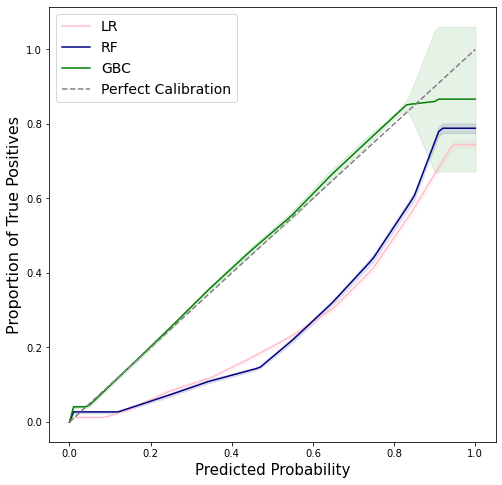

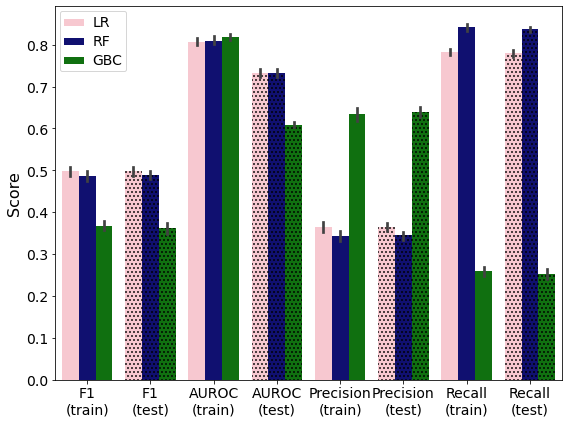

In [176]:
%%time

# get test performance

df = qa_df
model_dict = qa_model_dict
dataname = 'qa'


def plot_performance_and_calibration_updated(df, model_dict, dataname, train_ids, test_ids, save=False):
    '''
    -df here refers to qa_df, qa_plus_df, or t_df
    -model dict is the dictionary created by model training e.g. qa_model_dict which has training performance and the models
    -dataname labels the plots
    * importantly to use this function the train and test IDs need to be available as they get called
    '''
    #extract training performance dataframe from model-dict
    train_performance_df = pd.DataFrame()
    for model in ['lr','rf','gbc']:
        new_df = (
            pd.DataFrame(model_dict[model])
            .assign(model=model,train_test='train')
            .drop(columns=['fit_time','score_time','estimator'])
            .rename(columns={'test_f1':'f1s','test_roc_auc':'rocs','test_precision':'precisions','test_recall':'recalls'})
        )
        train_performance_df = pd.concat([train_performance_df,new_df],axis=0)

    # test against training data
    models = ['lr','rf','gbc']
    labels = ['LR', 'RF', 'GBC']
    positions = [1,2,3]
    colors = ['pink','navy','green']

    # get test data
    X_test = df.query('ALF_PE in @test_ids').drop(columns = ['ALF_PE','admit'])
    y_test = df.query('ALF_PE in @test_ids')['admit']

    scaler = MinMaxScaler()

    # scale test data
    X_test = model_dict['scaler'].transform(X_test)
    y_test = y_test.to_numpy()

    xlabel_size = 15
    ylabel_size = 16
    tick_size = 14
    legend_size = 14

    fig1, ax1 = plt.subplots(1,1, figsize=(8,8))

    global_rocs = []
    global_f1s = []
    global_precisions = []
    global_recalls = []
    global_labels =[]

    for model,label,position,color in zip(models,labels,positions,colors):

        all_rocs=[]
        all_f1s=[]
        all_recalls=[]
        all_precisions=[]
        tprs = []
        base_fpr = np.linspace(0,1,101)

        split_indexes = np.array_split(np.arange(len(X_test)),5)
        for idx in split_indexes:
            # get best model index based on best roc
            best_id = np.argmax(model_dict[model]['test_roc_auc'])
            best_model = model_dict[model]['estimator'][best_id]

            preds = best_model.predict(X_test[idx])
            # roc_score
            roc_score = roc_auc_score(y_test[idx], preds)
            all_rocs.append(roc_score)
            # f1_score
            f1 = f1_score(y_test[idx], preds)
            all_f1s.append(f1)
            # recall
            recall = recall_score(y_test[idx], preds)
            all_recalls.append(recall)
            # precision
            precision = precision_score(y_test[idx], preds)
            all_precisions.append(precision)
            # calibration plot
            probs = best_model.predict_proba(X_test[idx])
            prob_true, prob_pred = calibration_curve(y_test[idx], probs[:,1], n_bins=10)
            tpr = np.interp(base_fpr, prob_pred, prob_true)
            tpr[0] = 0.0
            tprs.append(tpr)

        global_rocs.append(all_rocs)
        global_f1s.append(all_f1s)
        global_precisions.append(all_precisions)
        global_recalls.append(all_recalls)
        global_labels.append([label for i in range(len(all_rocs))])

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        tprs_upper = mean_tprs + std
        tprs_lower = mean_tprs - std

        ax1.plot(base_fpr, mean_tprs, label=label,color=color)
        ax1.fill_between(base_fpr, tprs_lower, tprs_upper, alpha=0.1,color=color)

#         box = ax2.boxplot(all_rocs, positions=[position],patch_artist=True)
#         for box_ in box['boxes']:
#             box_.set(facecolor=color)

#         box = ax3.boxplot(all_f1s, positions=[position],patch_artist=True)
#         for box_ in box['boxes']:
#             box_.set(facecolor=color)
       
    
    # make a 
    # flatten list of lists
    global_rocs = [item for sublist in global_rocs for item in sublist]
    global_f1s = [item for sublist in global_f1s for item in sublist]
    global_precisions = [item for sublist in global_precisions for item in sublist]
    global_recalls = [item for sublist in global_recalls for item in sublist]
    global_labels = [item for sublist in global_labels for item in sublist]

    ax1.plot([0,1],[0,1],color='grey',linestyle='--',label=('Perfect Calibration'))
    ax1.set_xlabel('Predicted Probability',fontsize=xlabel_size)
    ax1.set_ylabel('Proportion of True Positives', fontsize=ylabel_size)
#     ax1.set_title(f'Calibration Curve for {dataname.upper()} Data', fontsize=20)
    ax1.legend(fontsize=legend_size)
    
    if save == True:
        fig1.savefig(path+f'thesis_plots/calibration_plot_{dataname}')
    else:
        pass
    
    # gather all data for testing performance

    test_performance_df = pd.DataFrame({
        'rocs':global_rocs, 
        'f1s':global_f1s, 
        'precisions':global_precisions, 
        'recalls':global_recalls, 
        'model':global_labels,
        'train_test':'test'
        })

    # replace names for plotting
    all_performance = (
        pd.concat([train_performance_df,test_performance_df])
        .assign(model = lambda x: x.model.replace({'lr':'LR','rf':'RF','gbc':'GBC'}))
    )
    
    # save performance 
    if save == True:
        pickle.dump(all_performance, open(path+f'all_performance_{dataname}','wb'))
    else:
        pass
    
    # plot train and test performance
    plot_df = (
    pd.melt(all_performance, id_vars=['model','train_test'])
    .assign(x_tick_names = lambda x: x[['train_test','variable']].agg('_'.join,axis=1))
    # remove 's' from name
    .assign(x_tick_names = lambda x: x.x_tick_names.apply(lambda y: y[:-1]))
    .assign(x_tick_names = lambda x: x.x_tick_names.replace({
        'train_f1':'F1\n(train)',
        'test_f1':'F1\n(test)',
        'train_roc':'AUROC\n(train)',
        'test_roc':'AUROC\n(test)',
        'train_precision':'Precision\n(train)',
        'test_precision':'Precision\n(test)',
        'train_recall':'Recall\n(train)',
        'test_recall':'Recall\n(test)',
    }))
    )

#     print(plot_df)
    
    palette = ({'LR':'pink', 'RF':'navy', 'GBC':'green'})

    order = ['F1\n(train)','F1\n(test)','AUROC\n(train)','AUROC\n(test)','Precision\n(train)','Precision\n(test)','Recall\n(train)','Recall\n(test)',]

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    sns.barplot(data=plot_df, x='x_tick_names',y='value',hue='model', order=order,
                palette = palette, 
                ax=ax)
    ax.set_xlabel('',fontsize=2)
    ax.set_ylabel('Score',fontsize=ylabel_size)
    ax.tick_params(labelsize=tick_size)
#     ax.set_title(f'Classifier Performance for {dataname.upper()} Data', fontsize=26)
    #update legend
    legend = ax.legend()
    legend.set_title(None)
    for label in legend.get_texts():
        label.set_fontsize(tick_size)
    ax.tick_params(axis='x',rotation=0)

    for i,bar in enumerate(ax.patches):
        if i%2!=0:
            bar.set_hatch('...')

    fig.tight_layout()
    
    if save == True:
        fig.savefig(path+f'thesis_plots/performance_plot_{dataname}')
    else:
        pass

    
#     return all_performance

plot_performance_and_calibration_updated(qa_df, qa_model_dict, 'qa', train_ids, test_ids, save=False)

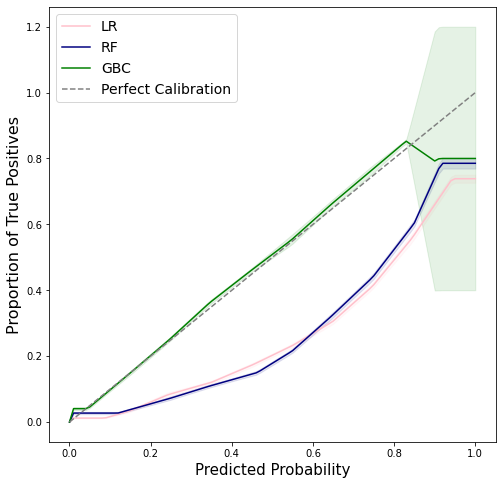

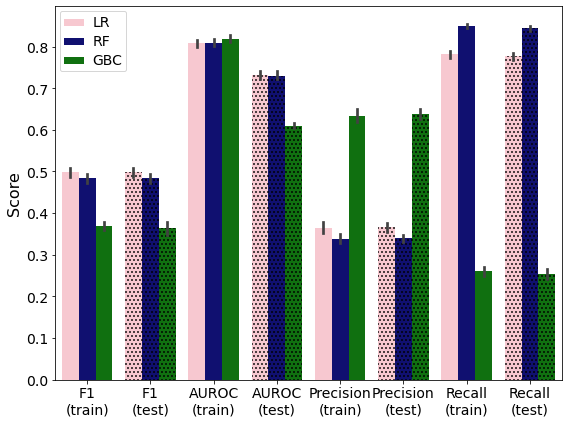

In [177]:
plot_performance_and_calibration_updated(qa_plus_df, qa_plus_model_dict, 'qa_plus', train_ids, test_ids, save=False)

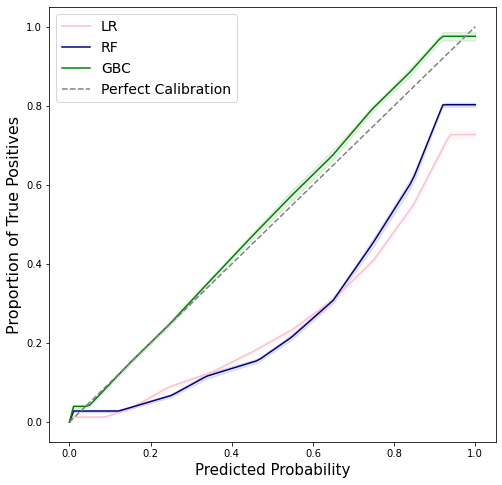

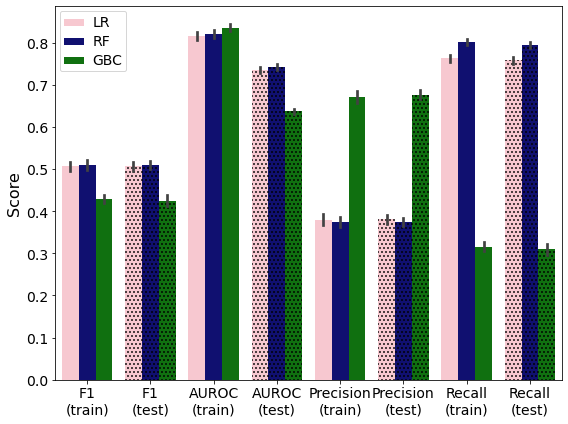

In [178]:
plot_performance_and_calibration_updated(t_df, t_model_dict, 't', train_ids, test_ids, save=False)